### Importing the Libraries

At first, we will load the libraries, that we will use to conduct the analysis.

In [1]:
# Basic imports
import pandas as pd
import numpy as np


# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns



# Sentiment analysis
#!pip install TextBlob

from textblob import TextBlob



Now, we will load the data. In total, we have 55 files that need to be loaded and merged. We will do this in the next step.

In [2]:
df = pd.read_csv("data/Kickstarter000.csv")

for i in range(1,56):
    
    num = str(1000 + i)
    
    dfi = pd.read_csv(f"data/Kickstarter{num[1:4]}.csv")
    df = pd.concat([df,dfi], axis = 0)

df.reset_index()    
df.to_csv("data/kickstarter_raw.csv")

The new data set contains 209222 observations and 37 columns.

In [3]:
df = pd.read_csv("data/kickstarter_raw.csv", index_col=0)

### Data Preparation

At first we need to get a overview of the data to see where data cleaning is needed.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209222 entries, 0 to 964
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             209222 non-null  int64  
 1   blurb                     209214 non-null  object 
 2   category                  209222 non-null  object 
 3   converted_pledged_amount  209222 non-null  int64  
 4   country                   209222 non-null  object 
 5   created_at                209222 non-null  int64  
 6   creator                   209222 non-null  object 
 7   currency                  209222 non-null  object 
 8   currency_symbol           209222 non-null  object 
 9   currency_trailing_code    209222 non-null  bool   
 10  current_currency          209222 non-null  object 
 11  deadline                  209222 non-null  int64  
 12  disable_communication     209222 non-null  bool   
 13  friends                   300 non-null     obje

- Since we have some variables of type "object" in the data set, which probably contain relevant information, we will explore them in more detail later.

- As we can see from above the variables **"blurb", "friends", "is_backing", "is_starred", "location", "permissions" and "usd_type"** contain missing values. The variables **"friends", "is_backing", "is_starred" and "permissions"** have more than 90% missings. We will delete them from our dataset and take care of of the other variables with missings later.

- Further variables that can be delete as they do not have any valuable information for our analysis are **"currency_symbol", currency_trailing_code", "photo", "source_url", "urls", state_changed_at", "spotlight", "disable_communication", "is_starrable"**. In the next step, we will delete them together with the variables that have more than 90% missings.


In [5]:
# Exclusion of the following columns from our data

df = df.drop(["currency_symbol",
         "currency_trailing_code",
         "friends",
         "is_backing",
         "is_starred",
         "permissions", 
         "photo",
         "source_url",
         "urls",
         "state_changed_at",
         "spotlight",
         "disable_communication",
         "is_starrable"], axis=1)



Further, we can see that the type of the columns **"created_at", "deadline" and "launched_at"** is not correct (integer instead of datetime format). In the next step, we will change that.

In addition, we will extract year, month and weekday out of the variables **"launched_at" and "dealine"** since we will later on explore these in more depth.

In [6]:
# convert unix date time to pandas datetime format
df['created_at'] = pd.to_datetime(df['created_at'],unit='s')
df['deadline'] = pd.to_datetime(df['deadline'],unit='s')
df['launched_at'] = pd.to_datetime(df['launched_at'],unit='s')

# pick out year, month and weekday out of date of launching
df['yr_launched'] = df['launched_at'].dt.year
df['mo_launched'] = df['launched_at'].dt.month
df['wd_launched'] = df['launched_at'].dt.weekday

# pick out year, month and weekday out of date of deadline
df['yr_deadline'] = df['deadline'].dt.year
df['mo_deadline'] = df['deadline'].dt.month
df['wd_deadline'] = df['deadline'].dt.weekday

For our analysis it could also be interesting to investigate the duration between deadline and launched date in more depth. Thus, we will also calculate the duration between the aformentioned variables.

In [7]:
# calculate duration of founding_phase (time between launching and deadline)
founding_phase = df['deadline'] - df['launched_at']
df['founding_phase'] = founding_phase.dt.days

# calculate duration of phase_before (time between creation and launcing)
phase_before = df['launched_at'] - df['created_at']
df['phase_before'] = phase_before.dt.days

The original variables **"deadline" and "launched_at"** are no longer needed. We can delete them.

In [8]:
# drop columns created_at, deadline, launched_at
df = df.drop(["created_at", "deadline", "launched_at"], axis=1)

Now lets have a look on our target variable **"state"**. This variable contains info about the outcome of the project (failed or successful). Before, we encode "state", we will explore this variable in more depth.

In [9]:
# Counts
df.state.value_counts()

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

We can see the variable "state" has 5 levels. Overall, most of the observations are labeled as "successful". For our research question only the levels "successful" and "failed" relevant. So, we exclude all other levels.

In [10]:
df = df.query('state in ["successful", "failed"]')

# Prove if it works
df.state.value_counts()

# Shape of df
df.shape

(192664, 29)

After dropping rows and colums the data set contains 192664 observations and 29 columns. 

At next, we will create dummy variables of the **"state" and "staff_pick"** variables as this makes it easier to work with them.



In [11]:
# Encoding of the state (target) variable:
df['state'] = df['state'].apply(lambda x: 1 if x == 'successful' else 0)

# 0 = failed
# 1 = sucessful

In [12]:
df['staff_pick'] = df['staff_pick'].apply(lambda x: 1 if x == True else 0)

Now, let's have a look at the frequency distribution of the individual variables in our data set. For this purpose, we will use histograms.

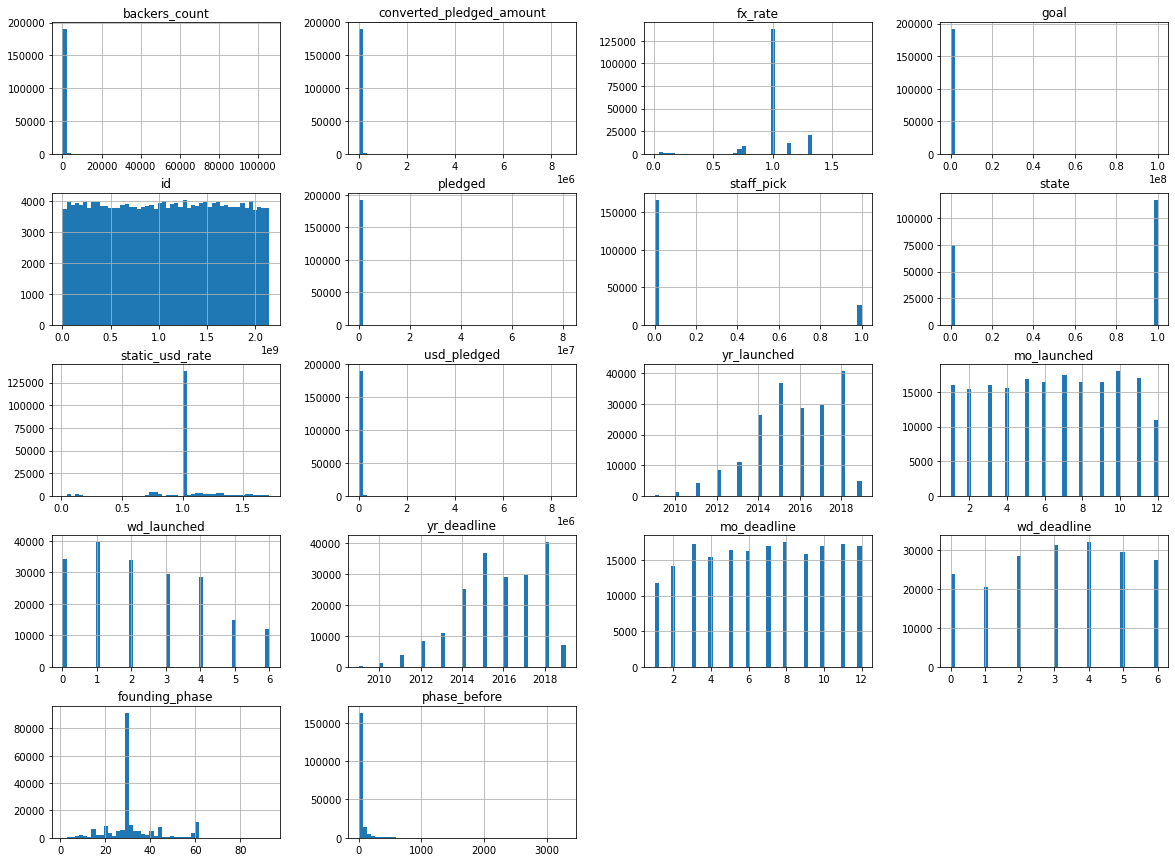

In [13]:
df.hist(bins=50, figsize = (20,15));

A first glance on the distribution reveals that:

- Many variables such as **"phase_before"** have outliers. As outliers can strongly affect our analysis we will exculde data from our df later. 
- Some variables are categorical like **"mo_lunched" and "staff_pick"** and other such ad **"founding_phase"** are numeric.


We have to calculate the goal in usd using the **"goal" and "static_usd_rate"**

In [14]:
df["goal_usd"] = df["goal"]*df["static_usd_rate"]

As outliers can strongly affect our analysis we exclude the highest 1.5% of our data.

In [15]:
# get 98.5% quantile (highest 1.5%) of 'phase_before', 'usd_pledged', 'goal_usd'
q_hi1  = df["phase_before"].quantile(0.985)
q_hi2  = df["usd_pledged"].quantile(0.985)
q_hi3  = df["goal_usd"].quantile(0.985)

# remove highest 1.5% percent of the data with the 98.5% quantiles
df = df[(df["phase_before"] < q_hi1) & (df["usd_pledged"] < q_hi2) & (df["goal_usd"] < q_hi3)]


Now, we come back to our variables that contain missing values.

In [16]:
df.isnull().sum()

backers_count                 0
blurb                         2
category                      0
converted_pledged_amount      0
country                       0
creator                       0
currency                      0
current_currency              0
fx_rate                       0
goal                          0
id                            0
location                    215
name                          0
pledged                       0
profile                       0
slug                          0
staff_pick                    0
state                         0
static_usd_rate               0
usd_pledged                   0
usd_type                     37
yr_launched                   0
mo_launched                   0
wd_launched                   0
yr_deadline                   0
mo_deadline                   0
wd_deadline                   0
founding_phase                0
phase_before                  0
goal_usd                      0
dtype: int64

As shown above, the variables **"location" and "usd_type"** contain a relatively small amount of missings. Since we are working with a large data set, deleting these rows should not be a problem.

In [17]:
# Drop rows which contain any NaN value in the selected columns
df = df.dropna( how='any',
                    subset=['location', 'usd_type', "blurb"])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184113 entries, 0 to 964
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             184113 non-null  int64  
 1   blurb                     184113 non-null  object 
 2   category                  184113 non-null  object 
 3   converted_pledged_amount  184113 non-null  int64  
 4   country                   184113 non-null  object 
 5   creator                   184113 non-null  object 
 6   currency                  184113 non-null  object 
 7   current_currency          184113 non-null  object 
 8   fx_rate                   184113 non-null  float64
 9   goal                      184113 non-null  float64
 10  id                        184113 non-null  int64  
 11  location                  184113 non-null  object 
 12  name                      184113 non-null  object 
 13  pledged                   184113 non-null  floa

Now we will explore variables of the type "object".

In [19]:
df[["blurb", "category", "country", "currency", "current_currency", "name", "profile", "slug", "usd_type", "location", "creator"]].head()

,blurb,category,country,currency,current_currency,name,profile,slug,usd_type,location,creator
0,2006 was almost 7 years ago.... Can you believ...,"{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",US,USD,USD,New Final Round Album,"{""id"":822687,""project_id"":822687,""state"":""inac...",new-final-round-album,international,"{""id"":2379574,""name"":""Chicago"",""slug"":""chicago...","{""id"":1495925645,""name"":""Daniel"",""is_registere..."
1,An adorable fantasy enamel pin series of princ...,"{""id"":54,""name"":""Mixed Media"",""slug"":""art/mixe...",US,USD,USD,Princess Pals Enamel Pin Series,"{""id"":3665299,""project_id"":3665299,""state"":""in...",princess-pals-enamel-pin-series,international,"{""id"":2486340,""name"":""Sacramento"",""slug"":""sacr...","{""id"":1175589980,""name"":""Katherine"",""slug"":""fr..."
2,Helping a community come together to set the s...,"{""id"":280,""name"":""Photobooks"",""slug"":""photogra...",US,USD,USD,Their Life Through Their Lens-the Amish and Me...,"{""id"":2730508,""project_id"":2730508,""state"":""in...",their-life-through-their-lens-the-amish-and-me...,international,"{""id"":2383660,""name"":""Columbus"",""slug"":""columb...","{""id"":1196856269,""name"":""MelissaThomas"",""is_re..."
3,Every revolution starts from the bottom and we...,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",IT,EUR,USD,WAO: THE ECO EFFECT SHOES,"{""id"":3498742,""project_id"":3498742,""state"":""ac...",wao-the-eco-effect-shoes,international,"{""id"":725746,""name"":""Venice"",""slug"":""venice-ve...","{""id"":1569700626,""name"":""WAO"",""slug"":""wearewao..."
4,Learn to build 10+ Applications in this comple...,"{""id"":51,""name"":""Software"",""slug"":""technology/...",US,USD,USD,Apple Watch Development Course,"{""id"":1754403,""project_id"":1754403,""state"":""in...",apple-watch-development-course,domestic,"{""id"":2479651,""name"":""Redmond"",""slug"":""redmond...","{""id"":1870845385,""name"":""Kalpit Jain"",""is_regi..."


The column **"creator", category" and "location"** contain dictionaries. We would like to extract the content of each column into separate columns. The **"profile"** coulmn contains a dictionary as well but the information provided is not useful for our analysis. Later on, we will drop this column.

In [20]:
df["category_dict"] = df["category"].apply(eval)
df_category = df["category_dict"].apply(pd.Series)
df_category.head()

,id,name,slug,position,parent_id,color,urls
0,43,Rock,music/rock,17,14.0,10878931,{'web': {'discover': 'http://www.kickstarter.c...
1,54,Mixed Media,art/mixed media,6,1.0,16760235,{'web': {'discover': 'http://www.kickstarter.c...
2,280,Photobooks,photography/photobooks,5,15.0,58341,{'web': {'discover': 'http://www.kickstarter.c...
3,266,Footwear,fashion/footwear,5,9.0,16752598,{'web': {'discover': 'http://www.kickstarter.c...
4,51,Software,technology/software,11,16.0,6526716,{'web': {'discover': 'http://www.kickstarter.c...


In [21]:
df_category["main_category"] = df_category["slug"].str.split("/").str[0]

In [22]:
df_category.head()

,id,name,slug,position,parent_id,color,urls,main_category
0,43,Rock,music/rock,17,14.0,10878931,{'web': {'discover': 'http://www.kickstarter.c...,music
1,54,Mixed Media,art/mixed media,6,1.0,16760235,{'web': {'discover': 'http://www.kickstarter.c...,art
2,280,Photobooks,photography/photobooks,5,15.0,58341,{'web': {'discover': 'http://www.kickstarter.c...,photography
3,266,Footwear,fashion/footwear,5,9.0,16752598,{'web': {'discover': 'http://www.kickstarter.c...,fashion
4,51,Software,technology/software,11,16.0,6526716,{'web': {'discover': 'http://www.kickstarter.c...,technology


In [23]:
df["main_category"] = df_category["main_category"] 
df["subcategory"] = df_category["name"]

In [24]:
df = df.drop(["category", "category_dict"], axis=1)

In [25]:
df["location"].fillna("{}", inplace = True)

df["location"] = df["location"].str.replace(',"is_root":false', "")
df["location"] = df["location"].str.replace(',"is_root":true', "" )
df["location"] = df["location"].str.replace('null', "{}" )

df["location_dict"] = df["location"].apply(eval)
df_location = df["location_dict"].apply(pd.Series)
df_location.head()

df["city"] = df_location["name"]
df["region"] = df_location["state"]
df["city_type"] = df_location["type"]

In [26]:
df = df.drop(["location", "location_dict"], axis=1)

In [27]:
df["creator_id"] = df["creator"].str[6:22]
df["creator_id"] = df["creator_id"].str.replace('"', "")
df["creator_id"] = df["creator_id"].str.split(",").str[0]
df["creator_id"] = df["creator_id"].astype(int)

df_creator = df[["creator_id","state"]].groupby("creator_id").count()
df_creator.rename(columns = {"state": "creator_num_projects"}, inplace = True)
df_creator.reset_index()

df = df.merge( df_creator, how = "left", on = "creator_id")

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184113 entries, 0 to 184112
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             184113 non-null  int64  
 1   blurb                     184113 non-null  object 
 2   converted_pledged_amount  184113 non-null  int64  
 3   country                   184113 non-null  object 
 4   creator                   184113 non-null  object 
 5   currency                  184113 non-null  object 
 6   current_currency          184113 non-null  object 
 7   fx_rate                   184113 non-null  float64
 8   goal                      184113 non-null  float64
 9   id                        184113 non-null  int64  
 10  name                      184113 non-null  object 
 11  pledged                   184113 non-null  float64
 12  profile                   184113 non-null  object 
 13  slug                      184113 non-null  o

The description of the project (**"blurb"**) could be a predictor of successful or failed projects. We will investigate this variable further. First, we will extract the number of words and then perform sentiment analysis.

In [29]:
# Extract number of words
df['words_blurb'] = df['blurb'].apply(lambda x: len(str(x).split()))

In [30]:
# Sentiment analysis
a = TextBlob(df.loc[1000, "blurb"])
print(df.loc[1000, "blurb"])
a.sentiment

Professional high quality Film Holders,  CNCed aluminum body, available in 4x5", 8x10"and 11x14". Proudly 100% Made in Sassuolo, Italy


Sentiment(polarity=0.365, subjectivity=0.51)

In [31]:
df['polarity_blurb'] = df['blurb'].apply(lambda x: TextBlob(str(x)).sentiment[0])
df['subjectivity_blurb'] = df['blurb'].apply(lambda x: TextBlob(str(x)).sentiment[1])

Finally, we will delete variables that are no longer needed and save the cleaned data.

In [32]:
df = df.drop(["creator",
             "blurb",
             "static_usd_rate",
             "fx_rate",
             "currency",
             "current_currency",
             "pledged",
             "goal",
             "profile",
             "converted_pledged_amount",
             "slug"], axis=1)

In [33]:
df.to_csv("data/data_clean.csv")
df = pd.read_csv("data/data_clean.csv", index_col=0)